# Transformer

这里我们将实现一个 Transformer 模型，将葡萄牙语翻译为英语。Transformer 的核心思想是 self-attention --通过关注序列不同位置的内容获取句子的表示。

Transformer的一些优点：

- 不受限于数据的时间/空间关系
- 可以并行计算
- 远距离 token 的相互影响不需要通过很长的时间步或很深的卷积层
- 可以学习远程依赖

Transformer的缺点：

- 对于时间序列，输出需要根据整个历史，而不是当前状态和输入，可能造成效率较低
- 如果想要获取时间空间信息，需要额外的位置编码

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
# 安装tfds pip install tfds-nightly==1.0.2.dev201904090105
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras.layers as layers

import time
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-rc0


## 数据输入 pipeline

我们将使用到Portugese-English翻译数据集。

该数据集包含大约50000个训练样例，1100个验证示例和2000个测试示例。

In [4]:
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True, as_supervised=True)

W0919 15:24:57.377556 140735620006784 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_datasets/core/file_format_adapter.py:209: tf_record_iterator (from tensorflow.python.lib.io.tf_record) is deprecated and will be removed in a future version.
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset ted_hrlr_translate downloaded and prepared to /Users/momo/tensorflow_datasets/ted_hrlr_translate/pt_to_en/0.0.1. Subsequent calls will reuse this data.


W0919 15:24:58.927920 140735620006784 dataset_builder.py:439] Warning: Setting shuffle_files=True because split=TRAIN and shuffle_files=None. This behavior will be deprecated on 2019-08-06, at which point shuffle_files=False will be the default for all splits.


将数据转化为subwords格式

In [5]:
train_examples, val_examples = examples['train'], examples['validation']

In [6]:
tokenizer_en = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(en.numpy() for pt, en in train_examples), target_vocab_size=2**13)
tokenizer_pt = tfds.features.text.SubwordTextEncoder.build_from_corpus(
(pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

token转化测试

In [7]:
sample_str = 'hello world, tensorflow 2'
tokenized_str = tokenizer_en.encode(sample_str)
print(tokenized_str)
original_str = tokenizer_en.decode(tokenized_str)
print(original_str)

[3222, 439, 150, 7345, 1378, 2824, 2370, 7881]
hello world, tensorflow 2


添加start、end的token表示

In [13]:
def encode(lang1, lang2):
    lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
        lang1.numpy()) + [tokenizer_pt.vocab_size+1]
    lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
        lang2.numpy()) + [tokenizer_en.vocab_size+1]
    return lang1, lang2

过滤长度超过40的数据

In [14]:
MAX_LENGTH=40
def filter_long_sent(x, y, max_length=MAX_LENGTH):
    return tf.logical_and(tf.size(x) <= max_length,
                         tf.size(y) <= max_length)

将python运算，转换为tensorflow运算节点

In [15]:
def tf_encode(pt, en):
    return tf.py_function(encode, [pt, en], [tf.int64, tf.int64])

## 构造数据集

In [16]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

# 使用.map()运行相关图操作
train_dataset = train_examples.map(tf_encode)
# 过滤过长的数据
train_dataset = train_dataset.filter(filter_long_sent)
# 使用缓存数据加速读入
train_dataset = train_dataset.cache()
# 打乱并获取批数据
train_dataset = train_dataset.padded_batch(
BATCH_SIZE, padded_shapes=([40], [40]))  # 填充为最大长度-90
# 设置预取数据
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 验证集数据
val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_long_sent).padded_batch(BATCH_SIZE, padded_shapes=([40], [40]))

In [17]:
de_batch, en_batch = next(iter(train_dataset))
de_batch, en_batch

(<tf.Tensor: id=207667, shape=(64, 40), dtype=int64, numpy=
 array([[8214,    7,  261, ...,    0,    0,    0],
        [8214,  116,   84, ...,    0,    0,    0],
        [8214,  155,   39, ...,    0,    0,    0],
        ...,
        [8214,  639,  590, ...,    0,    0,    0],
        [8214,  204, 3441, ...,    0,    0,    0],
        [8214,   27,   13, ...,    0,    0,    0]])>,
 <tf.Tensor: id=207668, shape=(64, 40), dtype=int64, numpy=
 array([[8087, 4670, 1783, ...,    0,    0,    0],
        [8087,   83,  145, ...,    0,    0,    0],
        [8087,  169,   56, ...,    0,    0,    0],
        ...,
        [8087,  174,   79, ...,    0,    0,    0],
        [8087,   11,   16, ...,    0,    0,    0],
        [8087,    4,   12, ...,    0,    0,    0]])>)

## 位置嵌入

将位置编码矢量添加得到词嵌入，相同位置的词嵌入将会更接近，但并不能直接编码相对位置

基于角度的位置编码方法如下：

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [18]:
def get_angles(pos, i, d_model):
    # 这里的i等价与上面公式中的2i和2i+1
    angle_rates = 1 / np.power(10000, (2*(i // 2))/ np.float32(d_model))
    return pos * angle_rates

In [19]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis,:],
                           d_model)
    # 第2i项使用sin
    sines = np.sin(angle_rads[:, 0::2])
    # 第2i+1项使用cos
    cones = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cones], axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding, dtype=tf.float32)

获得位置嵌入编码

(1, 50, 512)


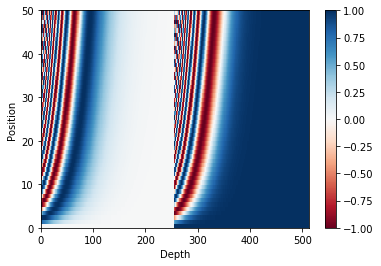

In [20]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show() # 在这里左右边分别为原来2i 和 2i+1的特征

## 掩码

为了避免输入中 padding 的 token 对句子语义的影响，需要将 padding 位 mark 掉，原来为 0 的 padding 项的 mark 输出为1

In [22]:
def create_padding_mark(seq):
    # 获取为0的padding项
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    
    # 扩充维度以便用于attention矩阵
    return seq[:, np.newaxis, np.newaxis, :] # (batch_size,1,1,seq_len)

# mark 测试
create_padding_mark([[1,2,0,0,3],[3,4,5,0,0]])

<tf.Tensor: id=207974, shape=(2, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]]], dtype=float32)>

look-ahead mask 用于对未预测的 token 进行掩码 这意味着要预测第三个单词，只会使用第一个和第二个单词。 要预测第四个单词，仅使用第一个，第二个和第三个单词，依此类推

In [23]:
def create_look_ahead_mark(size):
    # 1 - 对角线和取下三角的全部对角线（-1->全部）
    # 这样就可以构造出每个时刻未预测token的掩码
    mark = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mark  # (seq_len, seq_len)

In [24]:
# x = tf.random.uniform((1,3))
temp = create_look_ahead_mark(3)
print(temp)

tf.Tensor(
[[0. 1. 1.]
 [0. 0. 1.]
 [0. 0. 0.]], shape=(3, 3), dtype=float32)


## Scaled dot product attention

 ![sdp](./images/sdp_attention.png)
 进行attention计算的时候有3个输入 Q (query), K (key), V (value)。计算公式如下： $$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

点积注意力通过深度d_k的平方根进行缩放,因为较大的深度会使点积变大，由于使用softmax，会使梯度变小。 例如，考虑Q和K的均值为0且方差为1.它们的矩阵乘法的均值为0，方差为dk。我们使用dk的根用于缩放（而不是任何其他数字），因为Q和K的matmul应该具有0的均值和1的方差。

在这里我们将被掩码的token乘以-1e9(表示负无穷),这样softmax之后就为0,不对其他token产生影响。

In [25]:
def scaled_dot_product_attention(q, k, v, mask):
    # query key 相乘获取匹配关系
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    
    # 使用dk进行缩放
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # 掩码
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # 通过softmax获取attention权重
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    
    # attention 乘上value
    output = tf.matmul(attention_weights, v) # （.., seq_len_v, depth）
    
    return output, attention_weights

使用attention获取需要关注的语义

In [26]:
def print_out(q, k, v):
    temp_out, temp_att = scaled_dot_product_attention(
    q, k, v, None)
    print('attention weight:')
    print(temp_att)
    print('output:')
    print(temp_out)

attention测试

In [27]:
# 显示为numpy类型
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 3)
# 关注第2个key, 返回对应的value
temp_q = tf.constant([[0,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
output:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [28]:
# 关注重复的key(第3、4个), 返回对应的value（平均）
temp_q = tf.constant([[0,0,10]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
output:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [29]:
# 关注第1、2个key, 返回对应的value（平均）
temp_q = tf.constant([[10,10,0]], dtype=tf.float32)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
output:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [30]:
# 依次放入每个query
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

attention weight:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
output:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


## Mutil-Head Attention

![mh](./images/mh_attention.png)
mutil-head attention包含3部分：

- 线性层与分头
- 缩放点积注意力
- 头连接
- 末尾线性层

每个多头注意块有三个输入; Q（查询），K（密钥），V（值）。 它们通过第一层线性层并分成多个头。

注意:点积注意力时需要使用mask， 多头输出需要使用tf.transpose调整各维度。

Q，K和V不是一个单独的注意头，而是分成多个头，因为它允许模型共同参与来自不同表征空间的不同信息。 在拆分之后，每个头部具有降低的维度，总计算成本与具有全维度的单个头部注意力相同。

In [33]:
# 构造mutil head attention层
class MutilHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MutilHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # d_model 必须可以正确分为各个头
        assert d_model % num_heads == 0
        # 分头后的维度
        self.depth = d_model // num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        # 分头, 将头个数的维度 放到 seq_len 前面
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # 分头前的前向网络，获取q、k、v语义
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)
        v = self.wv(v)
        
        # 分头
        q = self.split_heads(q, batch_size) # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        # scaled_attention.shape == (batch_size, num_heads, seq_len_v, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        
        # 通过缩放点积注意力层
        scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
        # 把多头维度后移
        scaled_attention = tf.transpose(scaled_attention, [0, 2, 1, 3]) # (batch_size, seq_len_v, num_heads, depth)

        # 合并多头
        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))
        
        # 全连接重塑
        output = self.dense(concat_attention)
        return output, attention_weights


测试多头 attention

In [34]:
temp_mha = MutilHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))
output, att = temp_mha(y, k=y, q=y, mask=None)
print(output.shape, att.shape)

(1, 60, 512) (1, 8, 60, 60)


point wise 前向网络

In [35]:
def point_wise_feed_forward_network(d_model, diff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(diff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

In [36]:
sample_fnn = point_wise_feed_forward_network(512, 2048)
sample_fnn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 编码器和解码器

![](images/transformer.png)
- 通过N个编码器层，为序列中的每个字/令牌生成输出
- 解码器连接编码器的输出和它自己的输入（自我注意）以预测下一个字

### 编码层

每个编码层包含以下子层

- Multi-head attention（带掩码）
- Point wise feed forward networks

每个子层中都有残差连接，并最后通过一个正则化层。残差连接有助于避免深度网络中的梯度消失问题。 每个子层输出是LayerNorm(x + Sublayer(x))，规范化是在d_model维的向量上。Transformer一共有n个编码层。

In [37]:
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6, **kwargs):
        self.eps = epsilon
        super(LayerNormalization, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=tf.ones_initializer(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=tf.zeros_initializer(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
        
    def call(self, x):
        mean = tf.keras.backend.mean(x, axis=-1, keepdims=True)
        std = tf.keras.backend.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    
    def compute_output_shape(self, input_shape):
        return input_shape

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, ddf, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        
        self.mha = MutilHeadAttention(d_model, n_heads)
        self.ffn = point_wise_feed_forward_network(d_model, ddf)
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.dropout2 = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, inputs, training, mask):
        # 多头注意力网络
        att_output, _ = self.mha(inputs, inputs, inputs, mask)
        att_output = self.dropout1(att_output, training=training)
        out1 = self.layernorm1(inputs + att_output)  # (batch_size, input_seq_len, d_model)
        # 前向网络
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2

encoder层测试

In [39]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)
sample_encoder_layer_output = sample_encoder_layer(
tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape

TensorShape([64, 43, 512])

### 解码层